In [1]:
!gdown https://drive.google.com/file/d/10OWo4v3Op1UQe_rCQX-laToo9wffIPIp/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=10OWo4v3Op1UQe_rCQX-laToo9wffIPIp
To: /content/vlsp_sentiment_test.csv
100% 159k/159k [00:00<00:00, 88.6MB/s]


In [2]:
!gdown https://drive.google.com/file/d/1CEC49GoeBrCBY3gTGoIFiW0YB5LOZXVb/view?usp=sharing --fuzzy

Downloading...
From: https://drive.google.com/uc?id=1CEC49GoeBrCBY3gTGoIFiW0YB5LOZXVb
To: /content/vlsp_sentiment_train.csv
100% 858k/858k [00:00<00:00, 86.3MB/s]


In [3]:
!gdown https://drive.google.com/file/d/1d4hk9wBL_MYr0_XACe_67LgCooQYrThl/view?usp=sharing --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1d4hk9wBL_MYr0_XACe_67LgCooQYrThl
From (redirected): https://drive.google.com/uc?id=1d4hk9wBL_MYr0_XACe_67LgCooQYrThl&confirm=t&uuid=dde2cf9a-57ce-48b1-85ff-beabcfbae1b8
To: /content/vi-model-CBOW.bin
100% 699M/699M [00:07<00:00, 89.6MB/s]


In [4]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00


In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import digits
from collections import Counter
from pyvi import ViTokenizer
from gensim.models.word2vec import Word2Vec
from keras.utils import to_categorical
%matplotlib inline

In [6]:
data_train = pd.read_csv("vlsp_sentiment_train.csv", sep='\t')
data_train.columns =['Class', 'Data']
data_test = pd.read_csv("vlsp_sentiment_test.csv", sep='\t')
data_test.columns =['Class', 'Data']

In [7]:
print(data_train.shape)
print(data_test.shape)

(5100, 2)
(1050, 2)


In [8]:
labels = data_train.iloc[:, 0].values
reviews = data_train.iloc[:, 1].values

In [9]:
encoded_labels = []

for label in labels:
    if label == -1:
        encoded_labels.append([1,0,0])
    elif label == 0:
        encoded_labels.append([0,1,0])
    else:
        encoded_labels.append([0,0,1])

encoded_labels = np.array(encoded_labels)

In [10]:
reviews_processed = []
unlabeled_processed = []
for review in reviews:
    review_cool_one = ''.join([char for char in review if char not in digits])
    reviews_processed.append(review_cool_one)

In [11]:
#Use PyVi for Vietnamese word tokenizer
word_reviews = []
all_words = []
for review in reviews_processed:
    review = ViTokenizer.tokenize(review.lower())
    word_reviews.append(review.split())


In [12]:
EMBEDDING_DIM = 400 # how big is each word vector
MAX_VOCAB_SIZE = 10000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH = 300 # max number of words in a comment to use

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [14]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, lower=True, char_level=False)
tokenizer.fit_on_texts(word_reviews)
sequences_train = tokenizer.texts_to_sequences(word_reviews)
word_index = tokenizer.word_index


In [15]:
data = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
labels = encoded_labels

In [16]:
print('Shape of X train and X validation tensor:',data.shape)
print('Shape of label train and validation tensor:', labels.shape)

Shape of X train and X validation tensor: (5100, 300)
Shape of label train and validation tensor: (5100, 3)


In [17]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('vi-model-CBOW.bin', binary=True)


vocabulary_size=min(len(word_index)+1,MAX_VOCAB_SIZE)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
print("vocab size", vocabulary_size)
for word, i in word_index.items():
    if i>=MAX_VOCAB_SIZE:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

vocab size 7919


In [18]:
from keras.models import Model
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Reshape, Flatten,LSTM,GRU,Bidirectional
from keras.models import Model
from keras import regularizers
sequence_length = data.shape[1]
num_filters = 512
drop = 0.2

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)

################## LSTM ONLY ###############################
reshape = Reshape((sequence_length,EMBEDDING_DIM))(embedding)

################# SINGLE LSTM ####################
lstm_0 = Bidirectional(LSTM(num_filters))(reshape)

# YOU WANNA ADD MORE LSTM LAYERS? UNCOMMENT THIS #
# lstm_2 = LSTM(1024, return_sequences=True)(reshape)
# lstm_1 = LSTM(512, return_sequences=True)(lstm_2)
# lstm_0 = LSTM(256)(lstm_1)

dropout = Dropout(drop)(lstm_0)
output = Dense(units=3, activation='softmax',kernel_regularizer=regularizers.l2(0.01))(dropout)

# this creates a model that includes
model = Model(inputs, output)


adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, weight_decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 400)          3167600   
                                                                 
 reshape (Reshape)           (None, 300, 400)          0         
                                                                 
 bidirectional (Bidirection  (None, 1024)              3739648   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 3)                 3075      
                                                             

In [19]:
### IF YOU HAVE MODEL WEIGHT AND WANNA LOAD IT
#model.load_weights("model.h5")

In [19]:
#define callbacks
#early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
#callbacks_list = [early_stopping]
callbacks_list = []

model.fit(data, labels, epochs= 100, batch_size=512, callbacks=callbacks_list, shuffle=True) # validation_split=0.2,

Epoch 1/100
10/10 [==============================] - 24s 1s/step - loss: 1.1338 - accuracy: 0.4310
Epoch 2/100
10/10 [==============================] - 11s 1s/step - loss: 0.9703 - accuracy: 0.5708
Epoch 3/100
10/10 [==============================] - 11s 1s/step - loss: 0.8712 - accuracy: 0.6392
Epoch 4/100
10/10 [==============================] - 11s 1s/step - loss: 0.8869 - accuracy: 0.6473
Epoch 5/100
10/10 [==============================] - 11s 1s/step - loss: 0.7507 - accuracy: 0.7122
Epoch 6/100
10/10 [==============================] - 11s 1s/step - loss: 0.6531 - accuracy: 0.7590
Epoch 7/100
10/10 [==============================] - 12s 1s/step - loss: 0.5657 - accuracy: 0.7933
Epoch 8/100
10/10 [==============================] - 12s 1s/step - loss: 0.4622 - accuracy: 0.8439
Epoch 9/100
10/10 [==============================] - 12s 1s/step - loss: 0.4170 - accuracy: 0.8537
Epoch 10/100
10/10 [==============================] - 12s 1s/step - loss: 0.3481 - accuracy: 0.8980
Epoch 11/

In [20]:
labels_test = data_test.iloc[:, 0].values
reviews_test = data_test.iloc[:, 1].values

In [21]:
encoded_labels_test = []

for label_test in labels_test:
    if label_test == -1:
        encoded_labels_test.append([1,0,0])
    elif label_test == 0:
        encoded_labels_test.append([0,1,0])
    else:
        encoded_labels_test.append([0,0,1])

encoded_labels_test = np.array(encoded_labels_test)

In [22]:
reviews_processed_test = []
unlabeled_processed_test = []
for review_test in reviews_test:
    review_cool_one = ''.join([char for char in review_test if char not in digits])
    reviews_processed_test.append(review_cool_one)

In [23]:
#Use PyVi for Vietnamese word tokenizer
word_reviews_test = []
all_words = []
for review_test in reviews_processed_test:
    review_test = ViTokenizer.tokenize(review_test.lower())
    word_reviews_test.append(review_test.split())

In [24]:
sequences_test = tokenizer.texts_to_sequences(word_reviews_test)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
labels_test = encoded_labels_test

In [25]:
print('Shape of X train and X validation tensor:',data_test.shape)
print('Shape of label train and validation tensor:', labels_test.shape)

Shape of X train and X validation tensor: (1050, 300)
Shape of label train and validation tensor: (1050, 3)


In [26]:
score = model.evaluate(data_test, labels_test)

33/33 [==============================] - 2s 39ms/step - loss: 1.5450 - accuracy: 0.6838


In [27]:
print("%s: %.2f" % (model.metrics_names[0], score[0]))
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))


loss: 1.55
accuracy: 68.38%


In [28]:
%cd /content

/content


In [29]:
model.save_weights("model.h5")

In [30]:
predictions = model.predict(data_test)

33/33 [==============================] - 2s 35ms/step


In [31]:
predictions = predictions.argmax(axis = 1 )

In [32]:
labels_test_class = labels_test.argmax(axis = 1 )

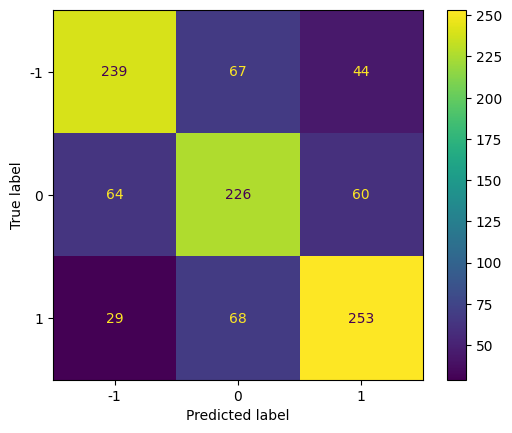

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
mtrx = confusion_matrix(labels_test_class, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=mtrx,display_labels=[-1,0,1])
disp.plot()